In [ ]:
pip install tensorflow-addons


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow_addons as tfa

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.15.0


In [10]:
import os
from distutils.dir_util import copy_tree
from shutil import rmtree

base_dir = "C:/Users/User/Alzheimer_s Dataset/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = os.path.join(base_dir, "test/")
train_dir = os.path.join(base_dir, "train/")
work_dir = os.path.join(root_dir, "dataset/")

if os.path.exists(work_dir):
    rmtree(work_dir)

os.makedirs(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))


Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [12]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
# Image Augmentation

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


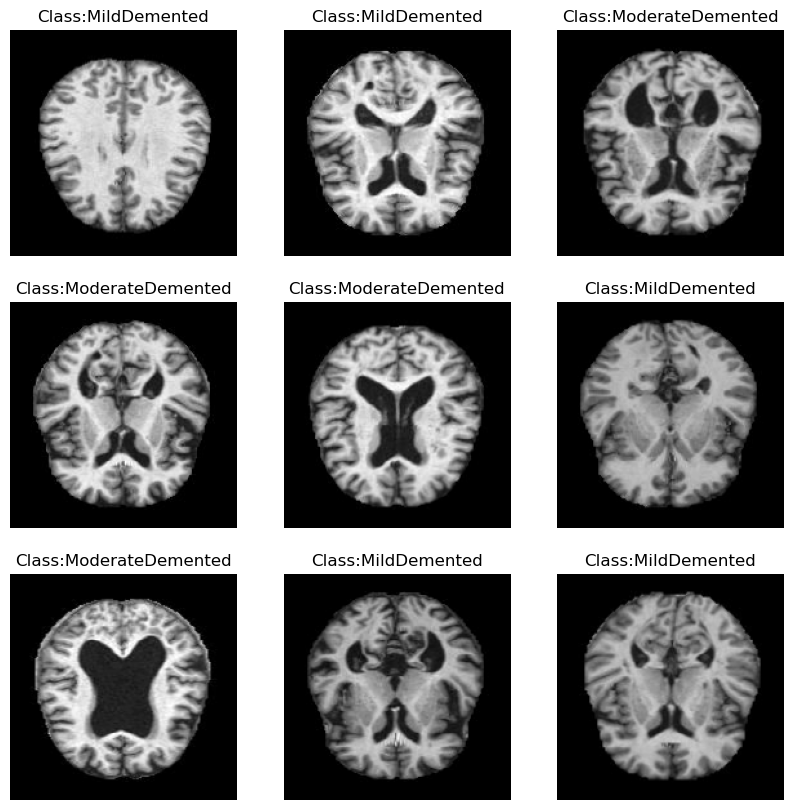

In [15]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [16]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [17]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [18]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [19]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Using the MobileNetV2 model as a base model for the task

In [ ]:
# Load MobileNetV2 as base model
mobilenet_model = MobileNetV2(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [21]:
# Freeze the layers of MobileNetV2
for layer in mobilenet_model.layers:
    layer.trainable = False

In [22]:
# Constructing your custom model
custom_mobilenet_model = Sequential([
    mobilenet_model,
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(4, activation='softmax')
], name="mobilenet_cnn_model")

In [23]:
# Define custom callback to stop training when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

my_callback = MyCallback()

# ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [24]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]

custom_mobilenet_model.compile(optimizer='rmsprop',
                                loss=tf.losses.CategoricalCrossentropy(),
                                metrics=METRICS)

custom_mobilenet_model.summary()


Model: "mobilenet_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 6, 6, 1280)        0         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                              

In [25]:
# Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = custom_mobilenet_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100

256/256 [==============================] - 58s 212ms/step - loss: 1.3271 - acc: 0.4373 - auc: 0.7097 - f1_score: 0.4309 - val_loss: 0.7460 - val_acc: 0.6602 - val_auc: 0.8998 - val_f1_score: 0.6493 - lr: 0.0010
Epoch 2/100
256/256 [==============================] - 51s 201ms/step - loss: 0.8806 - acc: 0.6024 - auc: 0.8601 - f1_score: 0.5974 - val_loss: 0.6219 - val_acc: 0.7217 - val_auc: 0.9293 - val_f1_score: 0.7215 - lr: 0.0010
Epoch 3/100
256/256 [==============================] - 54s 210ms/step - loss: 0.7410 - acc: 0.6698 - auc: 0.9005 - f1_score: 0.6682 - val_loss: 0.5644 - val_acc: 0.7539 - val_auc: 0.9435 - val_f1_score: 0.7532 - lr: 0.0010
Epoch 4/100
256/256 [==============================] - 51s 200ms/step - loss: 0.6653 - acc: 0.7090 - auc: 0.9210 - f1_score: 0.7087 - val_loss: 0.5121 - val_acc: 0.7778 - val_auc: 0.9526 - val_f1_score: 0.7757 - lr: 0.0010
Epoch 5/100
256/256 [==============================] - 52s 202ms/step - loss: 0.6302 - acc: 0.7349 - auc: 0

256/256 [==============================] - 51s 199ms/step - loss: 0.2248 - acc: 0.9235 - auc: 0.9896 - f1_score: 0.9233 - val_loss: 0.2454 - val_acc: 0.9077 - val_auc: 0.9882 - val_f1_score: 0.9066 - lr: 1.0000e-04
Epoch 37/100
256/256 [==============================] - 51s 199ms/step - loss: 0.2081 - acc: 0.9301 - auc: 0.9910 - f1_score: 0.9300 - val_loss: 0.2472 - val_acc: 0.9067 - val_auc: 0.9881 - val_f1_score: 0.9056 - lr: 1.0000e-05
Epoch 38/100
256/256 [==============================] - 52s 202ms/step - loss: 0.2262 - acc: 0.9241 - auc: 0.9890 - f1_score: 0.9240 - val_loss: 0.2445 - val_acc: 0.9082 - val_auc: 0.9884 - val_f1_score: 0.9071 - lr: 1.0000e-05
Epoch 39/100
256/256 [==============================] - 52s 205ms/step - loss: 0.2182 - acc: 0.9243 - auc: 0.9901 - f1_score: 0.9242 - val_loss: 0.2452 - val_acc: 0.9072 - val_auc: 0.9886 - val_f1_score: 0.9062 - lr: 1.0000e-05
Epoch 40/100
256/256 [==============================] - 53s 206ms/step - loss: 0.2010 - acc: 0.9329 -

Epoch 72/100
256/256 [==============================] - 50s 195ms/step - loss: 0.2132 - acc: 0.9268 - auc: 0.9906 - f1_score: 0.9265 - val_loss: 0.2454 - val_acc: 0.9053 - val_auc: 0.9885 - val_f1_score: 0.9042 - lr: 1.0000e-12
Epoch 73/100
256/256 [==============================] - 50s 195ms/step - loss: 0.2135 - acc: 0.9258 - auc: 0.9909 - f1_score: 0.9255 - val_loss: 0.2447 - val_acc: 0.9087 - val_auc: 0.9885 - val_f1_score: 0.9077 - lr: 1.0000e-12
Epoch 74/100
256/256 [==============================] - 50s 196ms/step - loss: 0.2025 - acc: 0.9314 - auc: 0.9915 - f1_score: 0.9313 - val_loss: 0.2459 - val_acc: 0.9072 - val_auc: 0.9884 - val_f1_score: 0.9061 - lr: 1.0000e-13
Epoch 75/100
256/256 [==============================] - 50s 196ms/step - loss: 0.2059 - acc: 0.9310 - auc: 0.9915 - f1_score: 0.9309 - val_loss: 0.2460 - val_acc: 0.9082 - val_auc: 0.9887 - val_f1_score: 0.9071 - lr: 1.0000e-13
Epoch 76/100
256/256 [==============================] - 49s 193ms/step - loss: 0.2034 - 

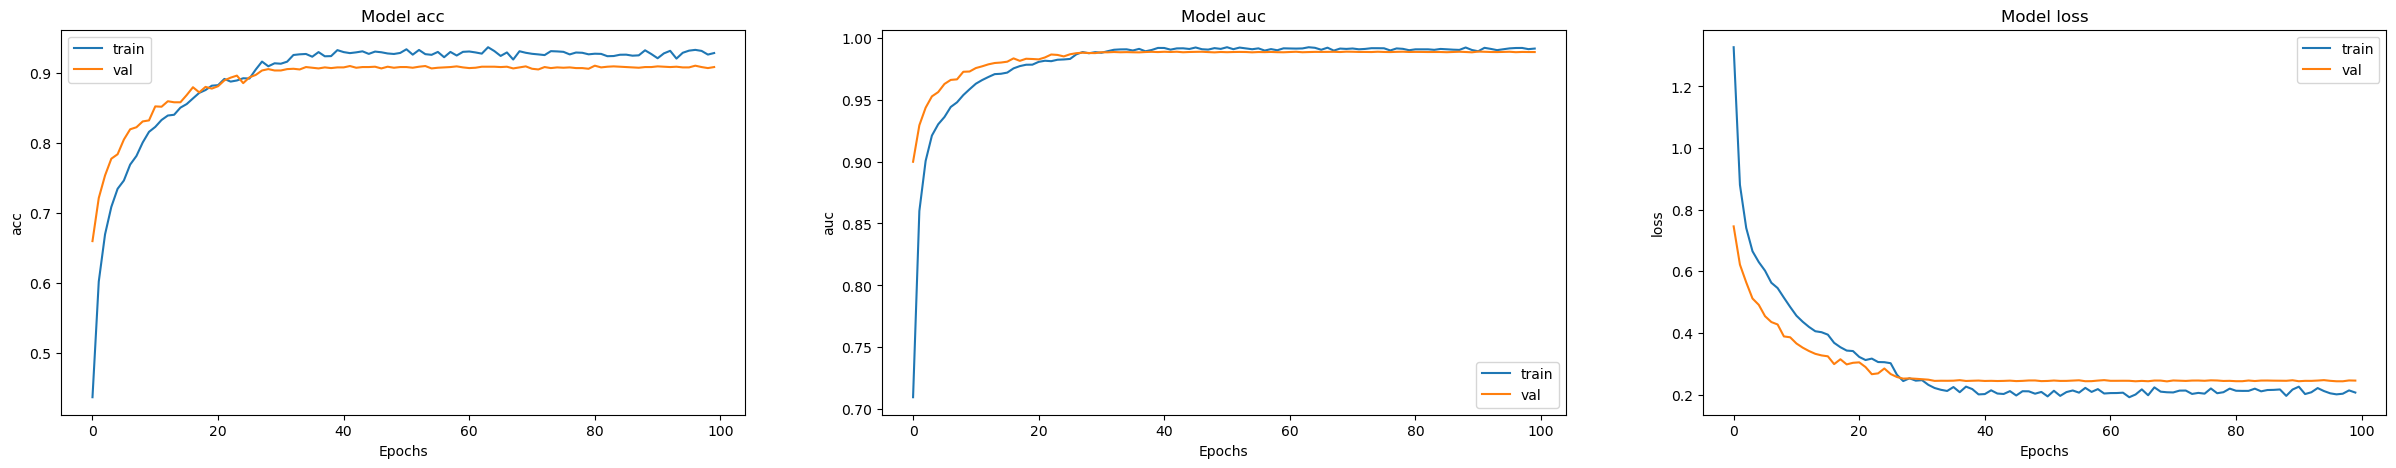

In [26]:
# Plotting the trend of the metrics during training
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [27]:
# Evaluating the model on the test data
test_scores = custom_mobilenet_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%" % (test_scores[1] * 100))

train_scores = custom_mobilenet_model.evaluate(train_data, train_labels)
val_scores = custom_mobilenet_model.evaluate(val_data, val_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))

80/80 [==============================] - 15s 183ms/step - loss: 0.2539 - acc: 0.9039 - auc: 0.9878 - f1_score: 0.9039
Testing Accuracy: 90.39%
64/64 [==============================] - 10s 159ms/step - loss: 0.2458 - acc: 0.9087 - auc: 0.9884 - f1_score: 0.9077
Training Accuracy: 99.60%
Validation Accuracy: 90.87%


In [28]:
# Predicting the test data
pred_labels = custom_mobilenet_model.predict(test_data)

80/80 [==============================] - 15s 161ms/step


In [29]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

# Print the classification report of the tested data
for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.94      0.96      0.95       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.86      0.83      0.84       662
ModerateDemented       0.82      0.83      0.82       624

       micro avg       0.90      0.90      0.90      2560
       macro avg       0.90      0.90      0.90      2560
    weighted avg       0.90      0.90      0.90      2560
     samples avg       0.90      0.90      0.90      2560



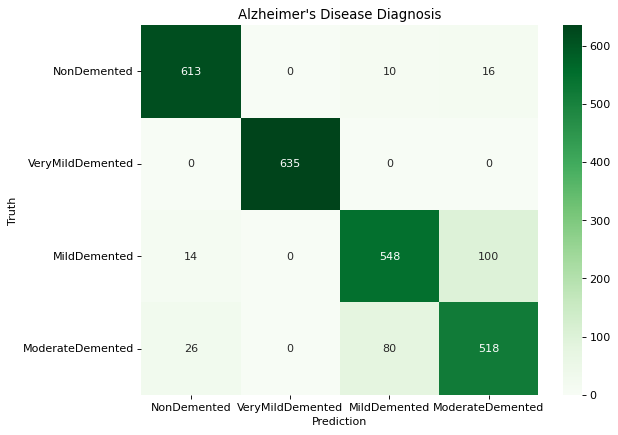

In [30]:
# Plot the confusion matrix to understand the classification in detail
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels = CLASSES, yticklabels=CLASSES)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [31]:
#Printing some other classification metrics
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 90.43 %
Matthew's Correlation Coefficient: 87.2 %


### Save

In [33]:
# Saving the model for future use === h5
custom_mobilenet_model_dir = work_dir + "alzheimer_mobilenet_cnn_model_new"
custom_mobilenet_model.save(custom_mobilenet_model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_mobilenet_cnn_model_new',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [34]:
import tensorflow as tf

# Load the saved model from the .h5 file
custom_mobilenet_model = tf.keras.models.load_model(custom_mobilenet_model_dir)

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(custom_mobilenet_model)
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_dir = work_dir + "alzheimer_mobilenet_cnn_model_new.tflite"
with open(tflite_model_dir, 'wb') as f:
    f.write(tflite_model)

# List the files in the working directory to verify the saved TFLite model
print(os.listdir(work_dir))


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpfucxczhn\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpfucxczhn\assets


['alzheimer_mobilenet_cnn_model_new', 'alzheimer_mobilenet_cnn_model_new.tflite', 'MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [53]:
# Load the saved model
pretrained_model = tf.keras.models.load_model(custom_mobilenet_model_dir)

# Check its architecture
tf.keras.utils.plot_model(pretrained_model, to_file=work_dir + "model_plot_new.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
